In [2]:
from google.colab import files
uploaded = files.upload()  # choose assignment2-rag.zip

import zipfile, io, os, shutil
zip_name = next(iter(uploaded))
extract_dir = "/content"
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as z:
    z.extractall(extract_dir)

# If it unzips with a top-level folder name, fix path:
!ls -1 /content
%cd /content/assignment2-rag

Saving assignment2-rag .zip to assignment2-rag .zip
assignment2-rag
'assignment2-rag .zip'
__MACOSX
sample_data
/content/assignment2-rag


In [5]:
import os, json, pandas as pd
from pathlib import Path
os.makedirs("results", exist_ok=True)

In [3]:
import matplotlib.pyplot as plt

In [4]:
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 21.6 MB/s eta 0:00:00


### Run naive RAG (top-1) for three prompt styles

In [ ]:
prompt_styles = ["instruction", "persona", "cot"]

for style in prompt_styles:
    tag = f"naive_top1_{style}"
    pred_path = f"results/{tag}.jsonl"

    # If predictions already exist, skip generation to save time
    if Path(pred_path).exists():
        print(f"Skip generation for {style} (found {pred_path})")
    else:
        print(f"Generating predictions for {style} …")
        # Runs your module; writes results/predictions_naive.jsonl
        !python -m src.naive_rag --run --top_k 1 --prompt_style {style}
        # Move into a unique file per style
        !mv -f results/predictions_naive.jsonl {pred_path}
        print(f"Saved {pred_path}")

流式输出内容被截断，只能显示最后 5000 行内容。
Batches: 100% 1/1 [00:00<00:00, 215.25it/s]
 31% 282/918 [02:25<09:23,  1.13it/s]
Batches: 100% 1/1 [00:00<00:00, 230.70it/s]
 31% 283/918 [02:27<10:27,  1.01it/s]
Batches: 100% 1/1 [00:00<00:00, 234.63it/s]

Batches: 100% 1/1 [00:00<00:00, 178.58it/s]
 31% 285/918 [02:27<07:25,  1.42it/s]
Batches: 100% 1/1 [00:00<00:00, 162.33it/s]
 31% 286/918 [02:27<06:01,  1.75it/s]
Batches: 100% 1/1 [00:00<00:00, 177.90it/s]
 31% 287/918 [02:28<05:15,  2.00it/s]
Batches: 100% 1/1 [00:00<00:00, 180.73it/s]
 31% 288/918 [02:29<07:54,  1.33it/s]
Batches: 100% 1/1 [00:00<00:00, 231.79it/s]
 31% 289/918 [02:29<06:11,  1.69it/s]
Batches: 100% 1/1 [00:00<00:00, 220.65it/s]
 32% 290/918 [02:30<05:23,  1.94it/s]
Batches: 100% 1/1 [00:00<00:00, 243.52it/s]

Batches: 100% 1/1 [00:00<00:00, 182.02it/s]
 32% 292/918 [02:30<03:22,  3.09it/s]
Batches: 100% 1/1 [00:00<00:00, 203.91it/s]
 32% 293/918 [02:30<04:05,  2.54it/s]
Batches: 100% 1/1 [00:00<00:00, 240.13it/s]
 32% 294/918 [02:31

### Evaluate

In [ ]:
%pip install evaluate
import evaluate

squad = evaluate.load("squad")

def compute_squad_metrics(pred_jsonl, gold_jsonl="data/evaluation/gold.jsonl"):
    preds, refs, gold_map = [], [], {}
    with open(gold_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            r = json.loads(line); gold_map[str(r["id"])] = r["answer"]
    with open(pred_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            r = json.loads(line); _id = str(r["id"])
            if _id in gold_map:
                preds.append({"id": _id, "prediction_text": r.get("pred_answer","")})
                refs.append({"id": _id, "answers": {"text":[gold_map[_id]], "answer_start":[0]}})
    if not preds:
        return {"n":0, "exact_match":0.0, "f1":0.0}
    m = squad.compute(predictions=preds, references=refs)
    m["n"] = len(preds)
    return m

rows = []
for style in prompt_styles:
    tag = f"naive_top1_{style}"
    preds_file = f"results/{tag}.jsonl"
    metrics = compute_squad_metrics(preds_file)
    out_json = f"results/{tag}_metrics.json"  # style-specific → no overwrite
    with open(out_json, "w") as f:
        json.dump({
            "system": "naive",
            "prompt_style": style,
            "top_k": 1,
            "n": metrics["n"],
            "hf_em": metrics["exact_match"],
            "hf_f1": metrics["f1"]
        }, f, indent=2)
    rows.append({
        "system": "naive",
        "prompt_style": style,
        "top_k": 1,
        "n": metrics["n"],
        "hf_em": metrics["exact_match"],
        "hf_f1": metrics["f1"]
    })

df_step3 = pd.DataFrame(rows).sort_values(["hf_f1","hf_em"], ascending=False)
df_step3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,system,prompt_style,top_k,n,hf_em,hf_f1
0,naive,instruction,1,918,31.808279,39.303824
1,naive,persona,1,918,16.557734,26.134967
2,naive,cot,1,918,0.000000,11.228227


### Save results

In [ ]:
# Write required comparison file; merge if it already exists
comp_path = Path("results/comparison_analysis.csv")
if comp_path.exists():
    old = pd.read_csv(comp_path)
    merged = (pd.concat([old, df_step3], ignore_index=True)
                .drop_duplicates(subset=["system","prompt_style","top_k"], keep="last"))
    merged.to_csv(comp_path, index=False)
else:
    df_step3.to_csv(comp_path, index=False)

# Optional: also write a Step 3-only table
df_step3.to_csv("results/step3_initial_eval.csv", index=False)

print("Wrote:", comp_path.as_posix(), "and results/step3_initial_eval.csv")
pd.read_csv(comp_path)

Wrote: results/comparison_analysis.csv and results/step3_initial_eval.csv


,system,prompt_style,top_k,n,hf_em,hf_f1
0,naive,instruction,1,918,31.808279,39.303824
1,naive,persona,1,918,16.557734,26.134967
2,naive,cot,1,918,0.000000,11.228227


### Visualization

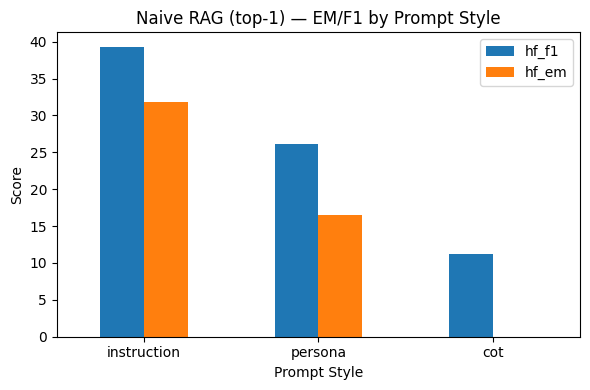

In [ ]:
import matplotlib.pyplot as plt

ax = df_step3.plot(kind="bar", x="prompt_style", y=["hf_f1","hf_em"], figsize=(6,4), rot=0)
ax.set_title("Naive RAG (top-1) — EM/F1 by Prompt Style")
ax.set_xlabel("Prompt Style")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

In [ ]:
# Zip the whole project
!zip -r assignment2-rag.zip /content/assignment2-rag

# Download to your laptop
from google.colab import files
files.download("assignment2-rag.zip")

流式输出内容被截断，只能显示最后 5000 行内容。
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/types/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/types/__init__.py (deflated 55%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/typing/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/typing/__init__.py (deflated 65%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/indexers/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/indexers/__init__.py (deflated 51%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/__init__.py (deflated 39%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/interchange/ (stored 0%)
  adding: content/assignment2-rag

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Phase 4: Experimentation (Embedding sizes,Retrieval variations)

In [6]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00


In [7]:
# Full sweep (covers 384 + 512 + 768 dims; top_k 3/5/10; 2+ strategies beyond top-1)
!python -m src.phase4_experiments --run

流式输出内容被截断，只能显示最后 5000 行内容。
Batches: 100% 1/1 [00:00<00:00, 106.06it/s]
 29% 263/918 [02:32<06:31,  1.67it/s]
Batches: 100% 1/1 [00:00<00:00, 219.33it/s]

Batches: 100% 1/1 [00:00<00:00, 192.83it/s]
 29% 265/918 [02:33<07:59,  1.36it/s]
Batches: 100% 1/1 [00:00<00:00, 226.61it/s]

Batches: 100% 1/1 [00:00<00:00, 201.67it/s]
 29% 267/918 [02:34<05:51,  1.85it/s]
Batches: 100% 1/1 [00:00<00:00, 216.20it/s]
 29% 268/918 [02:34<05:03,  2.14it/s]
Batches: 100% 1/1 [00:00<00:00, 227.43it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
 29% 269/918 [02:35<05:15,  2.06it/s]
Batches: 100% 1/1 [00:00<00:00, 223.16it/s]
 29% 270/918 [02:35<05:08,  2.10it/s]
Batches: 100% 1/1 [00:00<00:00, 201.32it/s]
 30% 271/918 [02:36<06:15,  1.72it/s]
Batches: 100% 1/1 [00:00<00:00, 202.36it/s]
 30% 272/918 [02:36<05:31,  1.95it/s]
Batches: 100% 1/1 [00:00<00:00, 196.52it/s]
 

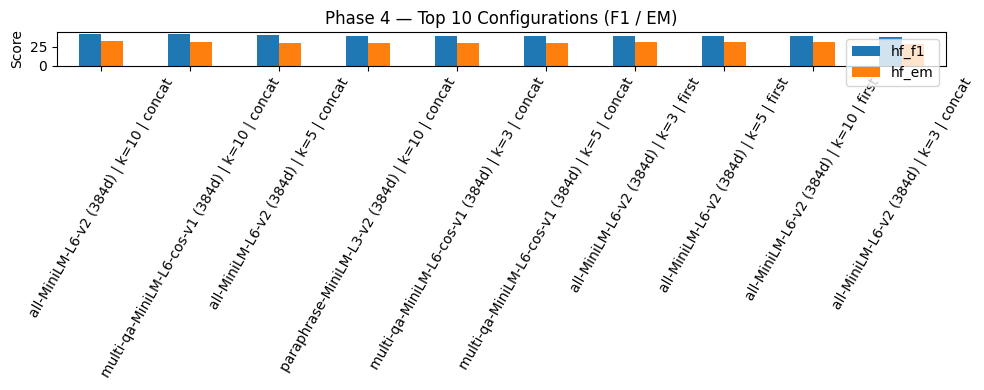

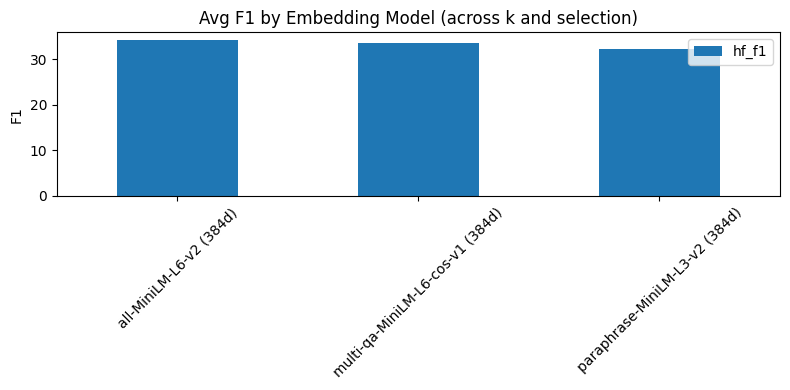

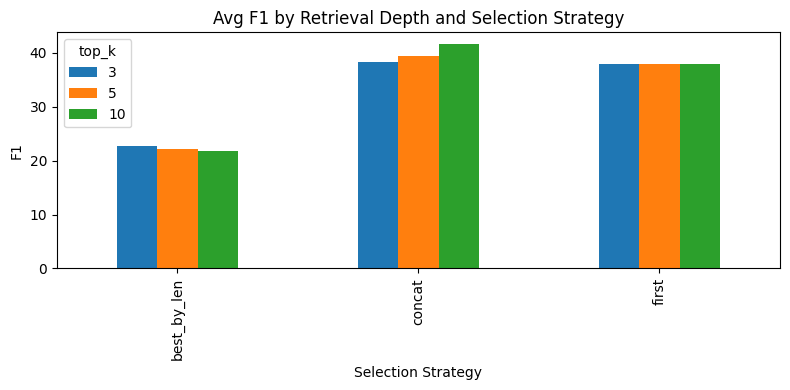

,embedding_model,embedding_dim,top_k,selection,hf_em,hf_f1
0,all-MiniLM-L6-v2,384,10,concat,32.571,42.635
1,multi-qa-MiniLM-L6-cos-v1,384,10,concat,32.135,42.325
2,paraphrase-MiniLM-L3-v2,384,10,concat,30.392,40.149


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load + focus on the Phase 4 sweep (instruction style to keep comparisons clean)
df = pd.read_csv("results/phase4_parameter_sweep.csv")
df = df.query("prompt_style == 'instruction'").copy()

# Pretty model labels with actual embedding dims (falls back to name if dim missing)
def pretty_model(row):
    dim = int(row["embedding_dim"]) if pd.notnull(row["embedding_dim"]) else None
    if dim:
        return f"{row['embedding_model']} ({dim}d)"
    return row["embedding_model"]

df["model_label"] = df.apply(pretty_model, axis=1)

# ---- 1) Top 10 configs by F1 (quick leaderboard) ----
df["label"] = (
    df["model_label"] + " | k=" + df["top_k"].astype(str) + " | " + df["selection"]
)
top10 = df.sort_values("hf_f1", ascending=False).head(10)

ax = top10.plot(kind="bar", x="label", y=["hf_f1", "hf_em"], rot=60, figsize=(10,4))
ax.set_title("Phase 4 — Top 10 Configurations (F1 / EM)")
ax.set_xlabel("")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

# ---- 2) Average F1 by embedding model (aggregated across k and selection) ----
by_model = df.groupby("model_label", as_index=False)["hf_f1"].mean().sort_values("hf_f1", ascending=False)

ax = by_model.plot(kind="bar", x="model_label", y="hf_f1", rot=45, figsize=(8,4))
ax.set_title("Avg F1 by Embedding Model (across k and selection)")
ax.set_xlabel("")
ax.set_ylabel("F1")
plt.tight_layout()
plt.show()

# ---- 3) Average F1 by (top_k × selection) to see retrieval behavior ----
by_k_sel = df.groupby(["top_k", "selection"], as_index=False)["hf_f1"].mean()
pivot_k_sel = by_k_sel.pivot(index="selection", columns="top_k", values="hf_f1").sort_index()

ax = pivot_k_sel.plot(kind="bar", figsize=(8,4))
ax.set_title("Avg F1 by Retrieval Depth and Selection Strategy")
ax.set_xlabel("Selection Strategy")
ax.set_ylabel("F1")
plt.tight_layout()
plt.show()

# ---- 4) (Optional) Quick table: best config per model ----
best_per_model = (df.sort_values(["embedding_model","hf_f1"], ascending=[True, False])
                    .groupby("embedding_model", as_index=False)
                    .first()[["embedding_model", "embedding_dim", "top_k", "selection", "hf_em", "hf_f1"]])
display(best_per_model.style.format({"hf_em":"{:.3f}", "hf_f1":"{:.3f}"}))

In [9]:
!zip -r assignment2-rag.zip /content/assignment2-rag

流式输出内容被截断，只能显示最后 5000 行内容。
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/types/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/types/__init__.py (deflated 55%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/typing/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/typing/__init__.py (deflated 65%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/indexers/ (stored 0%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/indexers/__init__.py (deflated 51%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/__init__.py (deflated 39%)
  adding: content/assignment2-rag/.venv/lib/python3.9/site-packages/pandas/api/interchange/ (stored 0%)
  adding: content/assignment2-rag

In [10]:
from google.colab import files
files.download("assignment2-rag.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>